# Demo Cromwell+IPython & Cost Analysis

Get a wdl and inputs that use a subworkflow and examine the capabilities of the tool to extract/obtain subworkflow metadata.

## Imports

In [1]:
# for workflow management
import json
import os
from google.cloud import storage
import cromwell_manager as cwm

with open(os.path.expanduser('~/.ssh/mint_cromwell_config.json')) as f:
    cromwell_server = cwm.Cromwell(**json.load(f))

storage_client = storage.Client(project='broad-dsde-mint-dev')

In [23]:
# parsing & plotting, later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

## Define a simple SS2 run
Define the input files for the workflow submission, submit, and store the submission pattern in one place - accepts as input: 

1. local files
2. gs files
3. https links
4. dictionaries/json (when appropriate)

In [85]:
workflow_root = 'https://raw.githubusercontent.com/HumanCellAtlas/skylab/master/smartseq2_single_sample/run_multi_samples/'

wdl = workflow_root + 'ss2_multi_sample_wf.wdl'
inputs = workflow_root + 'ss2_multi_sample_wf_demo.json'

# define our workflow options as a dict; we can pass this to the Workflow constructor
options_json = {
  "monitoring_script": "gs://broad-dsde-mint-dev-teststorage/10x/benchmark/scripts/monitor.sh",
  "read_from_cache": False,
  "write_to_cache": False
}

# also easier to pass dependencies this way, cwm.Cromwell will zip this for us.
dependencies = {
    'ss2_single_sample_wf.wdl': workflow_root + 'ss2_single_sample_wf.wdl'
}

In [86]:
# create the workflow and submit it
ss2_workflow = cwm.Workflow.from_submission(
    wdl=wdl, inputs_json=inputs, cromwell_server=cromwell_server, 
    storage_client=storage_client, workflow_dependencies=dependencies, options_json=options_json)

In [87]:
ss2_workflow.status

{'id': '59db621a-1161-4063-a92d-aa6b5345fcae', 'status': 'Submitted'}

In [ ]:
# wait for it to finish (will take a few minutes)
# ss2_workflow.wait_until_complete()

## Run an input with 10 cells

In [53]:
ten_sample_input = {
  "Ss2RunMultiSample.ref_fasta": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/Homo_sapiens_assembly19.fasta",
  "Ss2RunMultiSample.rsem_genome": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/rsem.tar",
  "Ss2RunMultiSample.ref_flat": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/Homo_sapiens_assembly19.refFlat",
  "Ss2RunMultiSample.sra_dir": "gs://broad-dsde-mint-dev-teststorage/patel_ap",
  "Ss2RunMultiSample.star_genome": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/star.tar",
  "Ss2RunMultiSample.sra_list_file": "gs://broad-dsde-mint-dev-teststorage/patel_ap/SRR_Acc_List_1_10.txt",  # changed this
  "Ss2RunMultiSample.rrna_interval": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/Homo_sapiens_assembly19.rRNA.interval_list",
  "Ss2RunMultiSample.gtf": "gs://broad-dsde-mint-dev-teststorage/reference/hg19/gencode.v19.annotation.gtf"
}

In [54]:
# create the workflow and submit it
ss2_10cells_workflow = cwm.Workflow.from_submission(
    wdl=wdl, inputs_json=ten_sample_input, cromwell_server=cromwell_server, 
    storage_client=storage_client, workflow_dependencies=dependencies, options_json=options_json)

In [58]:
ss2_10cells_workflow.status

{'id': 'c427b1dd-7f9a-4bad-9726-c21fc938591f', 'status': 'Succeeded'}

In [88]:
ss2_10cells_workflow.timing()

## Pick up from pre-run workflow

Alternatively, workflows can be generated from cromwell IDs to look at pre-run workflows

In [89]:
ss2_10cells_workflow = cwm.Workflow('c427b1dd-7f9a-4bad-9726-c21fc938591f', cromwell_server=cromwell_server, storage_client=storage_client)

## Examine the Inputs

This workflow has ten cells. What are they?

In [90]:
# download and print the input file
cwm.io_util.HTTPObject(inputs).download_as_string().split('\n')

['{',
 '  "Ss2RunMultiSample.sra_list_file": "gs://broad-dsde-mint-dev-teststorage/demo/sra_list.txt",',
 '  "Ss2RunMultiSample.sra_dir": "gs://broad-dsde-mint-dev-teststorage/demo",',
 '  "Ss2RunMultiSample.gtf": "gs://broad-dsde-mint-dev-teststorage/demo/gencodev19_chr21.gtf",',
 '  "Ss2RunMultiSample.ref_fasta": "gs://broad-dsde-mint-dev-teststorage/demo/chr21.fa",',
 '  "Ss2RunMultiSample.ref_flat": "gs://broad-dsde-mint-dev-teststorage/demo/refFlat.chr21.txt",',
 '  "Ss2RunMultiSample.rrna_interval": "gs://broad-dsde-mint-dev-teststorage/demo/hg19.chr21.rRNA.interval_list",',
 '  "Ss2RunMultiSample.star_genome": "gs://broad-dsde-mint-dev-teststorage/demo/star.tar",',
 '  "Ss2RunMultiSample.rsem_genome": "gs://broad-dsde-mint-dev-teststorage/demo/rsem.tar"',
 '}',
 '']

In [91]:
# download and cat the input list from the above file
cwm.io_util.GSObject('gs://broad-dsde-mint-dev-teststorage/patel_ap/SRR_Acc_List_1_10.txt').download_as_string().split('\n')

['SRR1294536',
 'SRR1294537',
 'SRR1294538',
 'SRR1294539',
 'SRR1294540',
 'SRR1294541',
 'SRR1294542',
 'SRR1294543',
 'SRR1294544',
 'SRR1294545',
 '']

Cool, so we can look at variation in memory and disk utilization

## Examine the workflow's memory and disk usage

This workflow contains a gather task `collect_all` and a subworkflow that's scattered across cells, `single_run`. Here we have ten cells, and thus ten subworkflows. 

In [92]:
ss2_10cells_workflow.tasks

{'Ss2RunMultiSample.collect_all': <CalledTask: Ss2RunMultiSample.collect_all, 1 shard(s)>,
 'Ss2RunMultiSample.single_run': [<SubWorkflow: 28e5f1aa-6e53-4179-808d-5066c66e2eb4>,
  <SubWorkflow: 674caac3-adba-4046-9441-6383081b3b35>,
  <SubWorkflow: 0a34f78c-3794-4953-8958-a14ef4442a00>,
  <SubWorkflow: 1505547d-730a-449f-97ec-f8b912de6f5a>,
  <SubWorkflow: def7e638-f495-481c-b8af-6bdd1f2e4b1d>,
  <SubWorkflow: f53728fd-405a-48e7-8a42-6b3bc07b7c52>,
  <SubWorkflow: ce93229f-75b8-48ed-ac19-a96e6cb35459>,
  <SubWorkflow: f1b6bd26-d63c-434e-a7bc-84882532c6c3>,
  <SubWorkflow: fefd3dd2-6fb2-4fc0-a954-e4f77aa79744>,
  <SubWorkflow: 542a7c1d-84a1-45d6-aec8-ed1245fffbcf>]}

Here's what the resource utilization looks like for the gather task:

In [94]:
print(ss2_10cells_workflow.tasks['Ss2RunMultiSample.collect_all'].resource_utilization)

GatherMetricsToTable Monitoring Summary:
Max Memory Usage (MB): 1811
Available Memory (MB): 3704
Max disk usage   (KB): 23272
Available disk   (KB): 10190136
Disk Utilized     (%): 0.002
Memory Utilized   (%): 0.489
Robust Estimate?     : True



Below I parse out the memory and disk allocation and usage for all the scattered tasks. I'll find a cleaner way of doing this later. 

In [105]:
max_memory = defaultdict(list)
available_memory = defaultdict(list)
max_disk = defaultdict(list)
available_disk = defaultdict(list)

def extract_info(task):
    """awful little side-effecting function to fill dictionaries"""
    ru = task.resource_utilization
    max_memory[task.name].append(ru.max_memory)
    max_disk[task.name].append(ru.max_disk)
    available_memory[task.name].append(ru.total_memory)
    available_disk[task.name].append(ru.total_disk)

for subworkflow in ss2_10cells_workflow.tasks['Ss2RunMultiSample.single_run']:
    for name, task in subworkflow.tasks.items():
        extract_info(task)

mean_max_memory = {key: np.max(val) for key, val in max_memory.items()}
var_max_memory = {key: np.std(val) for key, val in max_memory.items()}
mean_max_disk = {key: np.maxhttps://groups.google.com/a/openwdl.org/forum/#!forum/community(val) for key, val in max_disk.items()}
var_max_disk = {key: np.std(val) for key, val in max_disk.items()}
available_memory = {key: np.mean(val) for key, val in available_memory.items()}
available_disk = {key: np.mean(val) for key, val in available_disk.items()}

parsed_data = pd.DataFrame({
    'mean_max_memory': mean_max_memory,
    'var_max_memory': var_max_memory,
    'available_memory': available_memory,
    'mean_max_disk': mean_max_disk,
    'var_max_disk': var_max_disk,
    'available_disk': available_disk
    
})

Now, define a function and display the difference between allocated and utilized memory

In [96]:
def barplot(dataframe, column, label, ax, *args, **kwargs):
    ax.bar(left=np.arange(dataframe.shape[0]), height=dataframe[column], *args, **kwargs)
    ax.set_xticks(np.arange(dataframe.shape[0]));
    ax.set_xticklabels(list(i.replace('singlesample.Ss2RunSingleSample.', '') for i in dataframe.index), rotation=90)
    ax.set_xlim((-0.6, dataframe.shape[0] - 0.4));
    ax.set_ylabel(label)

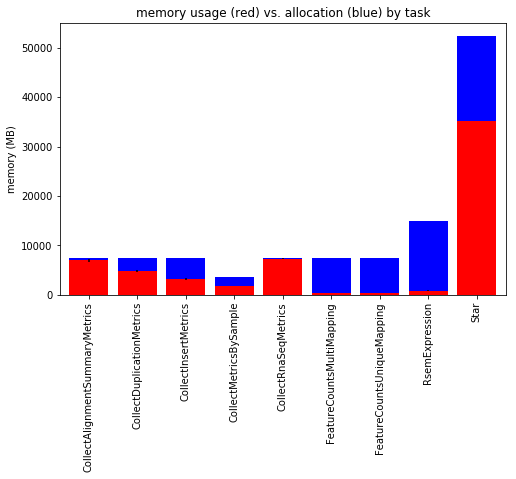

In [97]:
f, ax = plt.subplots(figsize=(8, 5))

barplot(dataframe=parsed_data, column='available_memory', label='memory (MB)', zorder=0, ax=ax, facecolor='b')
barplot(dataframe=parsed_data, column='mean_max_memory', label='memory (MB)', zorder=1, ax=ax, facecolor='r', 
        yerr=parsed_data['var_max_memory'])
plt.title('memory usage (red) vs. allocation (blue) by task');

And now allocated vs. utilized disk

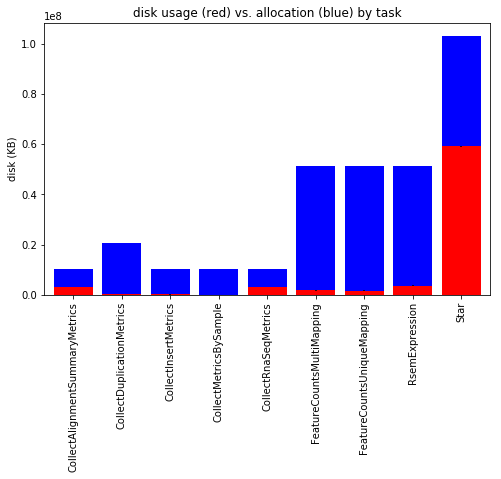

In [83]:
f, ax = plt.subplots(figsize=(8, 5))

barplot(dataframe=parsed_data, column='available_disk', label='disk (KB)', zorder=0, ax=ax, facecolor='b')
barplot(dataframe=parsed_data, column='mean_max_disk', label='disk (KB)', zorder=1, ax=ax, facecolor='r', 
        yerr=parsed_data['var_max_disk'])

plt.title('disk usage (red) vs. allocation (blue) by task');